# pytorch dataset 구현

# jsonl 데이터 불러오기

In [1]:
import torch
from torch.utils.data import Subset
import torch.nn as nn
import numpy as np
from sklearn.model_selection import StratifiedKFold
import torch.optim as optim
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import utils
from utils import Dataloader
from sklearn.metrics import f1_score
# from dataset_dataloader import Dataset


In [3]:
train_loader, test_loader = Dataloader()

# rnn 정의

In [2]:
class RNNClassifier(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        pad_token_id: int,
        num_labels: int,
        embedding_dim: int = 128,
        hidden_dim: int = 128,
        num_layers: int = 1,
        dropout: float = 0.1,
        rnn_type: str = "rnn",  # "rnn" | "gru" | "lstm"
    ):
        super().__init__()

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim,
            padding_idx=pad_token_id
        )

        rnn_type = rnn_type.lower()
        rnn_cls = {"rnn": nn.RNN, "gru": nn.GRU, "lstm": nn.LSTM}[rnn_type]
        self.rnn_type = rnn_type

        self.rnn = rnn_cls(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=False,                 # ✅ 단방향 고정
            dropout=dropout if num_layers > 1 else 0.0
        )

        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(hidden_dim, num_labels)

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor):
        """
        input_ids: (B, T)
        attention_mask: (B, T)  1=token, 0=pad
        """
        x = self.embedding(input_ids)           # (B, T, E)
        out, hidden = self.rnn(x)               # out: (B, T, H)

        # 마지막 실제 토큰 위치 계산
        lengths = attention_mask.sum(dim=1)     # (B,)
        last_idx = (lengths - 1).clamp(min=0)   # (B,)

        # out에서 각 배치별 마지막 토큰 hidden만 뽑기
        batch_idx = torch.arange(out.size(0), device=out.device)
        last_hidden = out[batch_idx, last_idx]  # (B, H)

        logits = self.classifier(self.dropout(last_hidden))  # (B, K)
        return logits


# 교차검증으로 모델 성능의 평균, 표준편차 확인



In [5]:


# 1)
def extract_labels(dataset, label_key="labels"):
    """
    StratifiedKFold용: dataset에서 샘플별 라벨을 1차원 numpy array로 추출
    """
    y = []
    for i in range(len(dataset)):
        label = dataset[i][label_key]
        # tensor → int
        if isinstance(label, torch.Tensor):
            label = label.item()
        y.append(int(label))
    return np.array(y, dtype=int)


# -------------------------
# 2) Subset 생성 함수
# -------------------------
def make_subset(dataset, indices):
    if not isinstance(indices, list):
        indices = indices.tolist()
    return Subset(dataset, indices)


# -------------------------
# 3) 1 epoch train/eval
# -------------------------
def run_one_epoch(model, loader, criterion, optimizer, device, train: bool):
    model.train() if train else model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        if train:
            optimizer.zero_grad()
            logits = model(input_ids, attention_mask)  # ⚠️ 네 모델 forward에 맞춰둠
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
        else:
            with torch.no_grad():
                logits = model(input_ids, attention_mask)
                loss = criterion(logits, labels)

        total_loss += loss.item() * labels.size(0)
        preds = logits.argmax(dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.append(preds.detach().cpu().numpy())
        all_labels.append(labels.detach().cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    return {
        "loss": total_loss / total,
        "acc": correct / total,
        "macro_f1": f1_score(all_labels, all_preds, average="macro"),
        "weighted_f1": f1_score(all_labels, all_preds, average="weighted"),
    }


# -------------------------
# 4) ✅ 5-Fold Stratified CV ONLY
# -------------------------
def train_rnn_cv5_only(
    dataset,                 # 전체 torch Dataset
    model_fn,                # model_fn() -> nn.Module (fold마다 새 모델)
    device,
    epochs=10,
    batch_size=16,
    lr=2e-4,
    weight_decay=0.0,
    num_workers=0,
    seed=42,
):
    labels = extract_labels(train_dataset, label_key="labels")  # ✅ labels 인자 제거: 내부에서 뽑음

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(labels, labels), start=1):

        print(f"\n========== Fold {fold}/5 ==========")

        train_subset = make_subset(dataset, train_idx)
        val_subset = make_subset(dataset, val_idx)

        train_loader = utils.DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        val_loader = utils.DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

        model = model_fn().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        best = None  # fold 내 best (val_macro_f1 기준)

        for epoch in range(1, epochs + 1):
            tr = run_one_epoch(model, train_loader, criterion, optimizer, device, train=True)
            va = run_one_epoch(model, val_loader, criterion, optimizer, device, train=False)

            print(
                f"[Fold {fold} | Epoch {epoch}] "
                f"train loss={tr['loss']:.3f} acc={tr['acc']:.3f} macroF1={tr['macro_f1']:.3f} | "
                f"val loss={va['loss']:.3f} acc={va['acc']:.3f} macroF1={va['macro_f1']:.3f}"
            )

            if (best is None) or (va["macro_f1"] > best["val_macro_f1"]):
                best = {
                    "fold": fold,
                    "best_epoch": epoch,
                    "val_loss": va["loss"],
                    "val_acc": va["acc"],
                    "val_macro_f1": va["macro_f1"],
                    "val_weighted_f1": va["weighted_f1"],
                }

        fold_results.append(best)
        print(
            f"--> Fold {fold} BEST @ epoch {best['best_epoch']}: "
            f"val_macro_f1={best['val_macro_f1']:.3f}, val_acc={best['val_acc']:.3f}, val_loss={best['val_loss']:.3f}"
        )

    # summary
    vals = {
        "val_loss": np.array([r["val_loss"] for r in fold_results], dtype=float),
        "val_acc": np.array([r["val_acc"] for r in fold_results], dtype=float),
        "val_macro_f1": np.array([r["val_macro_f1"] for r in fold_results], dtype=float),
        "val_weighted_f1": np.array([r["val_weighted_f1"] for r in fold_results], dtype=float),
    }
    summary = {k: (v.mean(), v.std(ddof=1)) for k, v in vals.items()}

    print("\n========== CV SUMMARY (mean ± std) ==========")
    for k, (m, s) in summary.items():
        print(f"{k:15s}: {m:.3f} ± {s:.3f}")

    return fold_results, summary


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vocab_size = train_loader.dataset.tokenizer.vocab_size
pad_id = train_loader.dataset.tokenizer.pad_token_id

train_dataset = train_loader.dataset

def model_fn():
    return RNNClassifier(
    vocab_size=vocab_size,
    pad_token_id=pad_id,
    num_labels = 4,
    embedding_dim=128,
    hidden_dim=256,
    # bidirectional=True,
    num_layers = 2,
    dropout=0.1,
    rnn_type="rnn",  # "gru"도 추천
).to(device)
   
fold_results, summary = train_rnn_cv5_only(
    dataset=train_dataset,
    model_fn=model_fn,
    device=device,
    epochs=10,
    batch_size=16,
    lr=2e-4,
)






========== Fold 1/5 ==========
[Fold 1 | Epoch 1] train loss=1.402 acc=0.244 macroF1=0.196 | val loss=1.394 acc=0.294 macroF1=0.222
[Fold 1 | Epoch 2] train loss=1.273 acc=0.519 macroF1=0.421 | val loss=1.406 acc=0.235 macroF1=0.166
[Fold 1 | Epoch 3] train loss=1.190 acc=0.556 macroF1=0.456 | val loss=1.413 acc=0.265 macroF1=0.180
[Fold 1 | Epoch 4] train loss=1.104 acc=0.674 macroF1=0.571 | val loss=1.440 acc=0.265 macroF1=0.187
[Fold 1 | Epoch 5] train loss=1.011 acc=0.733 macroF1=0.694 | val loss=1.467 acc=0.176 macroF1=0.140


KeyboardInterrupt: 

# 최종 평가

In [4]:



def run_one_epoch(model, loader, criterion, optimizer, device, train: bool):
    model.train() if train else model.eval()

    total_loss = 0.0
    correct = 0
    total = 0
    all_preds, all_labels = [], []

    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        if train:
            optimizer.zero_grad()
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
        else:
            with torch.no_grad():
                logits = model(input_ids, attention_mask)
                loss = criterion(logits, labels)

        total_loss += loss.item() * labels.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.append(preds.detach().cpu().numpy())
        all_labels.append(labels.detach().cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    return {
        "loss": total_loss / total,
        "acc": correct / total,
        "macro_f1": f1_score(all_labels, all_preds, average="macro"),
        "weighted_f1": f1_score(all_labels, all_preds, average="weighted"),
        "y_true": all_labels,
        "y_pred": all_preds,
    }


def train_final_and_test(
    train_dataset,
    test_dataset,
    model_fn,
    device,
    epochs=5,
    batch_size=16,
    lr=2e-4,
    weight_decay=0.0,
    num_workers=0,
    seed=42,
           
):
    torch.manual_seed(seed)
    np.random.seed(seed)

   
    train_ds = train_dataset
     

    train_loader = utils.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader  = utils.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    # -------------------------
    # 2) model/opt
    # -------------------------
    model = model_fn().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_state = None
    best_metric = -1.0
    best_epoch = 0

    # -------------------------
    # 3) Train epochs
    # -------------------------
    train_result = {
    "train_loss": [],
    "train_acc": [],
    "macrof1": [],
}



    for epoch in range(1, epochs + 1):
        tr = run_one_epoch(model, train_loader, criterion, optimizer, device, train=True)
        train_result['train_loss'].append(round(tr['loss'], 3))
        train_result['train_acc'].append(round(tr['acc'], 3))
        train_result['macrof1'].append(round(tr['macro_f1'], 3))  
                
        print(f"[Epoch {epoch}] train loss={tr['loss']:.4f} acc={tr['acc']:.4f} macroF1={tr['macro_f1']:.4f}")



    # -------------------------
    # 5) Test evaluation (딱 1번)
    # -------------------------
    test_metrics = run_one_epoch(model, test_loader, criterion, optimizer=None, device=device, train=False)

    print("\n========== TEST RESULT ==========")
    print(f"test loss={test_metrics['loss']:.4f} acc={test_metrics['acc']:.4f} macroF1={test_metrics['macro_f1']:.4f} weightedF1={test_metrics['weighted_f1']:.4f}")

    # 상세 리포트
    print("\n[Classification Report]")
    print(classification_report(test_metrics["y_true"], test_metrics["y_pred"], digits=4))

    print("\n[Confusion Matrix]")
    print(confusion_matrix(test_metrics["y_true"], test_metrics["y_pred"]))

    return model, test_metrics, train_result


In [5]:
train_loader, test_loader = Dataloader()
train_dataset = train_loader.dataset
test_dataset = test_loader.dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vocab_size = train_loader.dataset.tokenizer.vocab_size
pad_id = train_loader.dataset.tokenizer.pad_token_id


def final_model_fn():
    return RNNClassifier(
        vocab_size=vocab_size,
        pad_token_id=pad_id,
        num_labels=4,
        embedding_dim=128,
        hidden_dim=256,
        num_layers=2,
        dropout=0.1,
        rnn_type="rnn",   
    )

final_model, test_metrics, train_result = train_final_and_test(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    model_fn=final_model_fn,
    device=device,
    epochs=10,
    batch_size=16,
    lr=2e-4,
    
)


[Epoch 1] train loss=1.3946 acc=0.2189 macroF1=0.1893
[Epoch 2] train loss=1.2807 acc=0.4556 macroF1=0.3700
[Epoch 3] train loss=1.1882 acc=0.5740 macroF1=0.4658
[Epoch 4] train loss=1.0964 acc=0.6805 macroF1=0.5586
[Epoch 5] train loss=0.9853 acc=0.7278 macroF1=0.6760
[Epoch 6] train loss=0.8397 acc=0.8166 macroF1=0.7802
[Epoch 7] train loss=0.6729 acc=0.8817 macroF1=0.8683
[Epoch 8] train loss=0.5086 acc=0.9290 macroF1=0.9204
[Epoch 9] train loss=0.3571 acc=0.9527 macroF1=0.9497
[Epoch 10] train loss=0.2409 acc=0.9822 macroF1=0.9802

========== TEST RESULT ==========
test loss=1.7101 acc=0.2791 macroF1=0.3025 weightedF1=0.2923

[Classification Report]
              precision    recall  f1-score   support

           0     0.5000    0.3846    0.4348        13
           1     0.1818    0.1818    0.1818        11
           2     0.1667    0.2308    0.1935        13
           3     0.5000    0.3333    0.4000         6

    accuracy                         0.2791        43
   macro avg

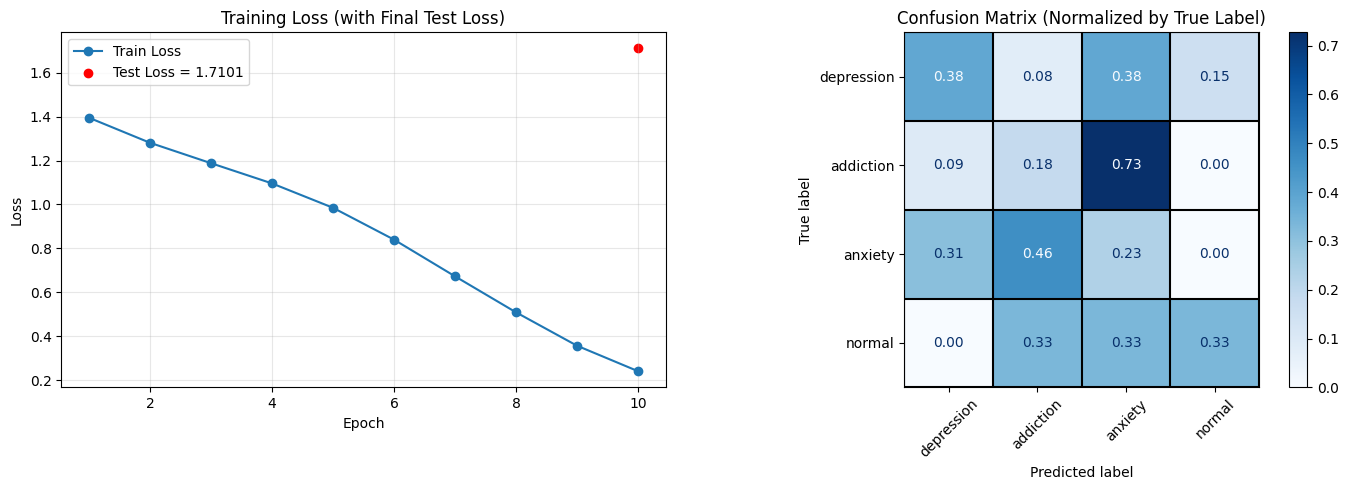

In [6]:


# ----------------------------
train_losses = train_result["train_loss"]                 # epoch별 기록(list)
test_loss = test_metrics.get("loss", None)                # 최종 test loss (있으면 표시)
y_true = np.array(test_metrics["y_true"])
y_pred = np.array(test_metrics["y_pred"])



# ----------------------------
# 1) Class names (네 설명 반영: 3=normal)
# ----------------------------
labels = [0, 1, 2, 3]
label_names = ["depression", "addiction", "anxiety", "normal"]  # 원하는 이름으로 바꿔도 됨

# ----------------------------
# 2) Make one figure with 2 panels
# ----------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# ---- (A) Loss curve ----
epochs = np.arange(1, len(train_losses) + 1)
ax1.plot(epochs, train_losses, marker="o", label="Train Loss")

if test_loss is not None:
    test_loss = float(test_loss)
    ax1.scatter(x = 10, y=test_loss, marker='o', color = 'red', label=f"Test Loss = {test_loss:.4f}")

ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss (with Final Test Loss)")
ax1.grid(True, alpha=0.3)
ax1.legend()

# ---- (B) Confusion matrix ----
cm = confusion_matrix(
    y_true,
    y_pred,
    labels=labels,
    normalize="true"    # 🔥 행 기준 비율 (각 클래스의 정답률)
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=label_names
)

disp.plot(
    ax=ax2,
    cmap="Blues",
    colorbar=True,
    values_format=".2f",   # 🔥 비율 표시
    xticks_rotation=45
)

# ----------------------------
# 셀 경계선 강조
# ----------------------------
n_classes = cm.shape[0]
for i in range(n_classes + 1):
    ax2.axhline(i - 0.5, color="black", linewidth=1.5)
    ax2.axvline(i - 0.5, color="black", linewidth=1.5)

ax2.set_title("Confusion Matrix (Normalized by True Label)")

plt.tight_layout()
plt.show()
